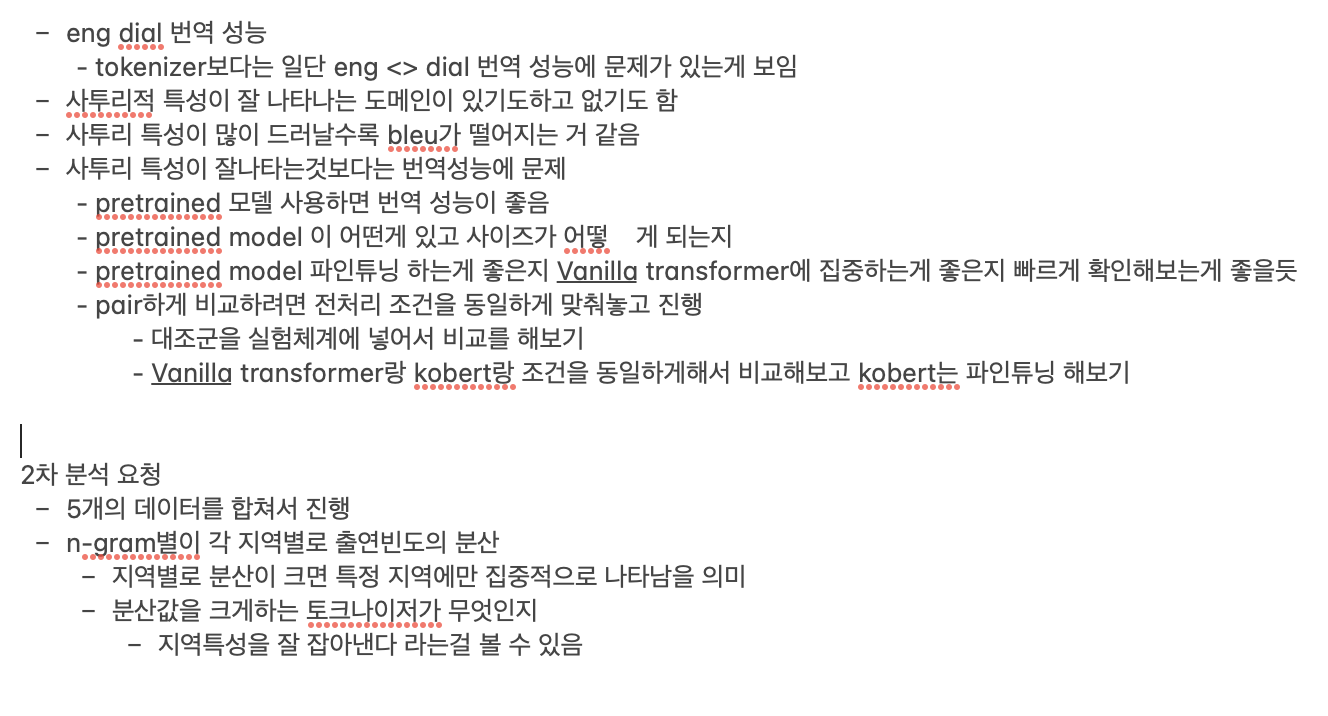

In [13]:
import os 
import pandas as pd 
import numpy as np 
import re
import tqdm 
import matplotlib.pyplot as plt
import pickle

from nltk import ngrams
import seaborn as sns

In [14]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from collections import Counter
import sentencepiece as spm

In [15]:
# ! pip install pandas==1.5.3
print(pd.__version__)

1.5.3


In [16]:
directory = os.getenv('HOME') + '/aiffel/aiffelthon'

In [17]:
df_train = pd.read_pickle(directory + '/data_train_spm_4000_0317.pkl','gzip')
df_test = pd.read_pickle(directory + '/data_test_spm_4000_0317.pkl','gzip')
df_test['weight'] = df_test['tok_cat'].apply(lambda x : 14 - x)
df_test = df_test.loc[df_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림, 250개만 사용

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340262 entries, 0 to 1340261
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   reg       1340262 non-null  object
 1   topic     1340262 non-null  object
 2   eng       1340262 non-null  object
 3   dial      1340262 non-null  object
 4   tok_len   1340262 non-null  int64 
 5   tok_cat   1340262 non-null  int64 
 6   toks_en   1340262 non-null  object
 7   toks_dec  1340262 non-null  object
dtypes: int64(2), object(6)
memory usage: 81.8+ MB


In [19]:
df_train.head()

reg topic                                                eng  \
0  jd    역사            <jd> I've changed my mind a little bit.   
1  jd    가족  <jd> You know what? Foreigners still get used ...   
2  jd    건강  <jd> All of a sudden, I think I've ripped off ...   
3  jd   스타일  <jd> I have a lot of ideas about getting older...   
4  jd   먹거리   <jd> It's a little bit of a tastey, but still...   

                                     dial  tok_len  tok_cat  \
0                          생각이 쪼금씩 바뀌드라고        10        1   
1                웜마 알겄는가 애국인들이 그또 달 적응하고        17        1   
2             아으 갑자기 에전에 맹장 뜯은 게잉 생각난디야.        22        1   
3  보먼은 좀 품위 있게 나이 들어가야 되겠단 싱각을 참 마이 해요잉.        18        1   
4            약깐 좀 약깐 맛이가 쪼까 머시기 카긴 한디 그또        18        1   

                                             toks_en  \
0  [3981, 5, 3981, 3, 46, 854, 94, 810, 11, 79, 1...   
1  [3981, 5, 3981, 3, 14, 141, 106, 4005, 3981, 3...   
2  [3981, 5, 3981, 3, 48, 56, 11, 796, 3, 3981, 3...   
3  [3981, 5, 3981, 3, 104, 11, 155, 56, 2402, 67,...   
4  [3981, 5, 3981, 3, 3983, 3, 3988, 11, 79, 138,...   

                                            toks_dec  
0  [1, 796, 177, 2655, 2831, 107, 3353, 293, 2448...  
1  [1, 733, 37, 2765, 1673, 130, 2675, 2477, 89, ...  
2  [1, 11, 2488, 1667, 280, 763, 856, 2542, 2448,...  
3  [1, 1545, 44, 2448, 2911, 2736, 15, 2461, 361,...  
4  [1, 155, 44, 155, 239, 141, 897, 1053, 2463, 8...

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1362 to 893
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       250 non-null    object
 1   topic     250 non-null    object
 2   eng       250 non-null    object
 3   dial      250 non-null    object
 4   tok_len   250 non-null    int64 
 5   tok_cat   250 non-null    int64 
 6   toks_en   250 non-null    object
 7   toks_dec  250 non-null    object
 8   weight    250 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 19.5+ KB


In [21]:
df_test.head(5)

reg     topic                                                eng  \
1362  kw        문학  <kw> Maybe they're just left out somewhere in ...   
503   jj  자동차/오토바이            <jj> Oh, I was in a terrible situation.   
1269  kw        문학  <kw> So I'm going to Asacusa somewhere. I thin...   
73    jd        쇼핑  <jd> I don't know why we're so angry when we'r...   
183   jd       먹거리  <jd> Itas going to burst out so how did you ea...   

                                                   dial  tok_len  tok_cat  \
1362                             잘뭇허먼 컴 어인가에 거냥 방치돼서요.        15        1   
503                                  아게 나야말러레 억울한 상황이연        12        1   
1269  그러니까 어디가더라 아사쿠사에 갈 거예요.  집이는 아쭈 존 친구라고 생각해요.  ...       75        4   
73                            울 왜케 쇼핑하시로 분노하는 건지 모르겄는디        18        1   
183                   배불러 터지겠는디 그래가꼬 뭐~ 어뜨케 해가꼬 맨 먹었지.        16        1   

                                                toks_en  \
1362  [3981, 8, 3981, 3, 65, 634, 181, 3, 17, 132, 7...   
503   [3981, 4, 3981, 3, 3989, 3, 3981, 3, 86, 64, 1...   
1269  [3981, 8, 3981, 3, 3984, 3981, 3, 3995, 153, 3...   
73    [3981, 5, 3981, 3, 84, 3, 3983, 141, 200, 76, ...   
183   [3981, 5, 3981, 3, 3983, 67, 153, 30, 3317, 17...   

                                               toks_dec  weight  
1362  [1, 75, 3372, 2508, 2613, 1646, 16, 531, 2466,...      13  
503   [1, 286, 18, 2492, 2509, 355, 1435, 2547, 2489...      13  
1269  [1, 1707, 585, 2450, 541, 11, 2474, 3006, 2474...      10  
73    [1, 72, 147, 2522, 1932, 2459, 986, 219, 2605,...      13  
183   [1, 209, 2629, 2516, 1129, 2456, 2589, 55, 723...      13

In [22]:
# check duplicates
print('train duplicated count :' ,df_train.duplicated(subset='dial').sum())
print('test duplicated count :' ,df_test.duplicated(subset='dial').sum())

train duplicated count : 0
test duplicated count : 0


In [23]:
# check for any overlaps in train and test
tr_dial = df_train.dial.values
ts_dial = df_test.dial.values
temp_ = np.concatenate([tr_dial, ts_dial], axis=0)
temp_ = print('overlap count : ',pd.DataFrame(temp_).duplicated().sum())

overlap count :  0


## 지역별 데이터 분포 

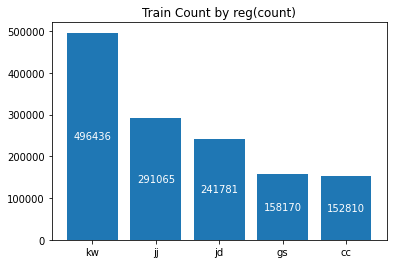

In [24]:
# count per region
data = df_train.reg.value_counts()
# data_ts = df_test.reg.value_counts(normalize=True).multiply(100).round(2)

fig, ax = plt.subplots()
p = ax.bar(data.index, data)
ax.bar_label(p, label_type='center', color='white')
plt.title("Train Count by reg(count)")
plt.show()

### import

In [25]:
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.font_manager as fm

### import tokenizer

In [26]:
data_path = os.getenv('HOME') +'/PocLab/Preprocessing'

spm_4000 = spm.SentencePieceProcessor()
spm_4000.Load(data_path + '/vocab_4000/spm_dec_v.model')


spm_8000 = spm.SentencePieceProcessor()
spm_8000.Load(data_path + '/vocab_8000/spm_dec_8009.model')

msp_4000 = spm.SentencePieceProcessor()
msp_4000.Load(data_path + '/vocab_4000/spm_dec_mecab_4009.model')

msp_8000 = spm.SentencePieceProcessor()
msp_8000.Load(data_path + '/vocab_8000/spm_dec_msp8009.model')

custom_msp_4000 = spm.SentencePieceProcessor()
custom_msp_4000.Load(data_path + '/vocab_4000/spm_dec_custom_msp4009.model')

custom_msp_8000 =  spm.SentencePieceProcessor()
custom_msp_8000.Load(data_path + '/vocab_8000/spm_dec_custom_msp8009.model')


True

### spm

In [27]:
regs = ['kw','jj','cc','gs','jd']

In [28]:
colors = ['#0B1D77','#0045A5','#0A69C1','#198AC5','#27A9B5']

100%|██████████| 241781/241781 [00:19<00:00, 12699.13it/s]
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: Runtime

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0,

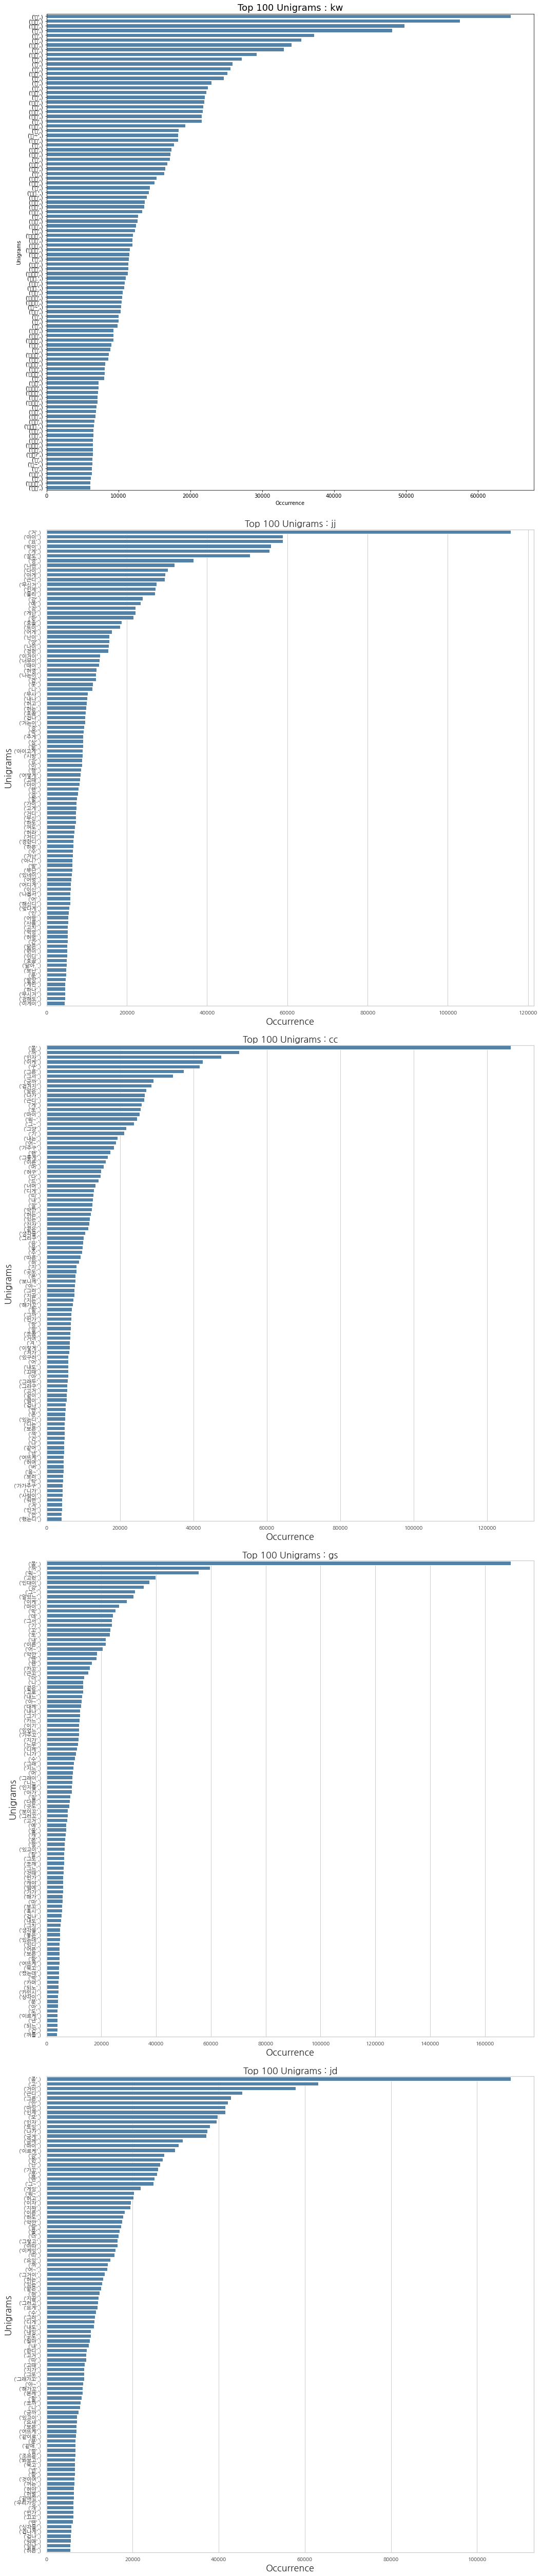

In [29]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Unigrams', title = f'Top 100 Unigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

100%|██████████| 241781/241781 [00:19<00:00, 12324.66it/s]


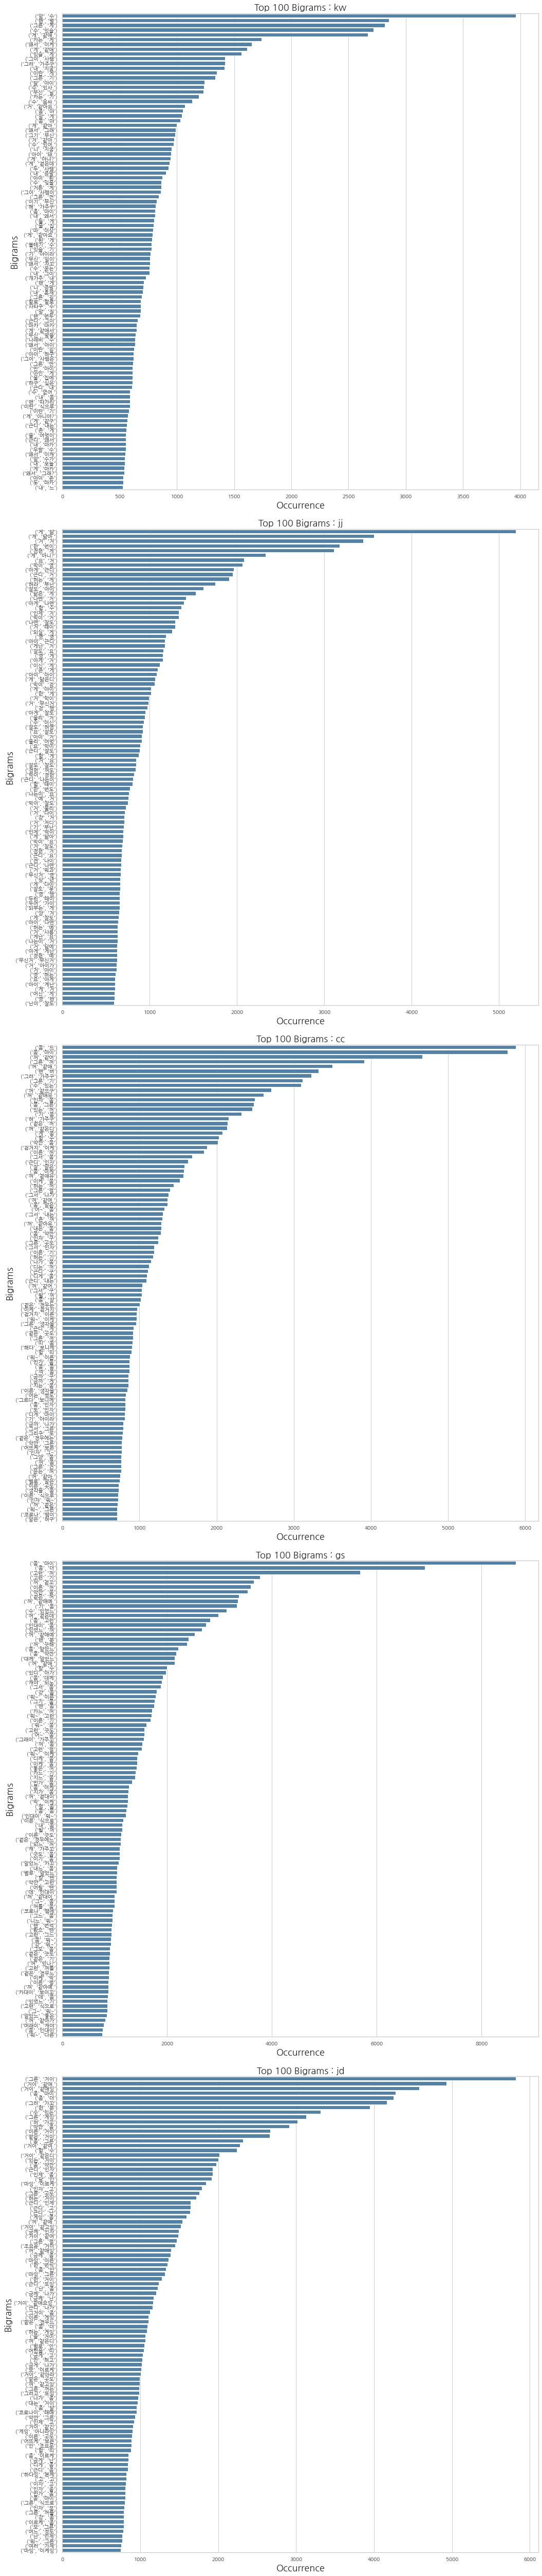

In [17]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,2)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Bigrams', title = f'Top 100 Bigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

100%|██████████| 241781/241781 [00:19<00:00, 12170.40it/s]


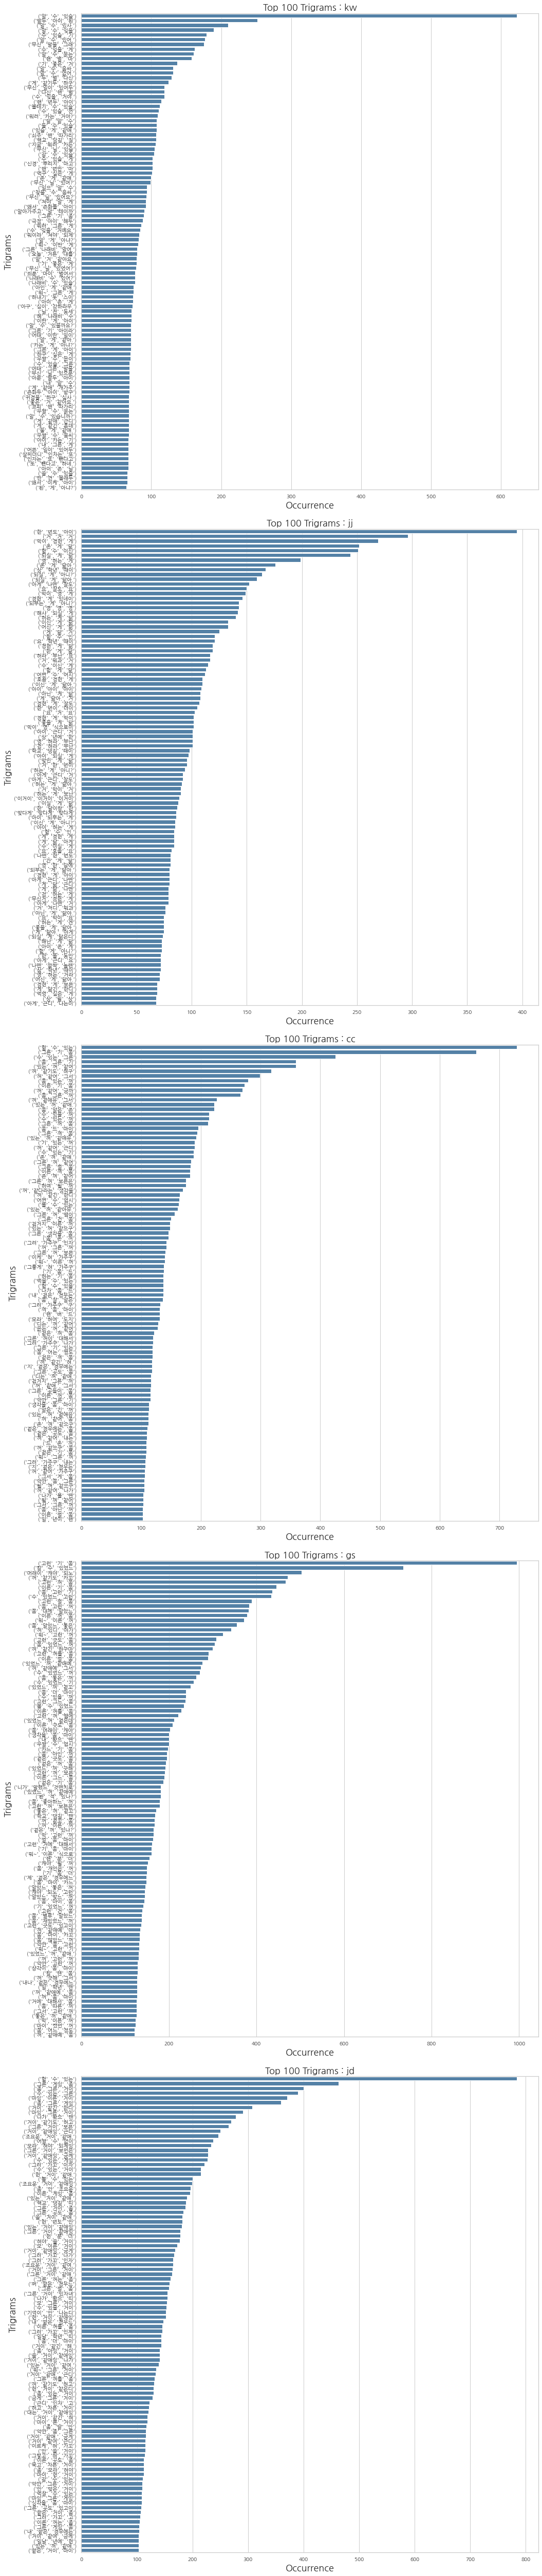

In [18]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,3)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Trigrams', title = f'Top 100 Trigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

### msp

100%|██████████| 241781/241781 [00:17<00:00, 13909.88it/s]


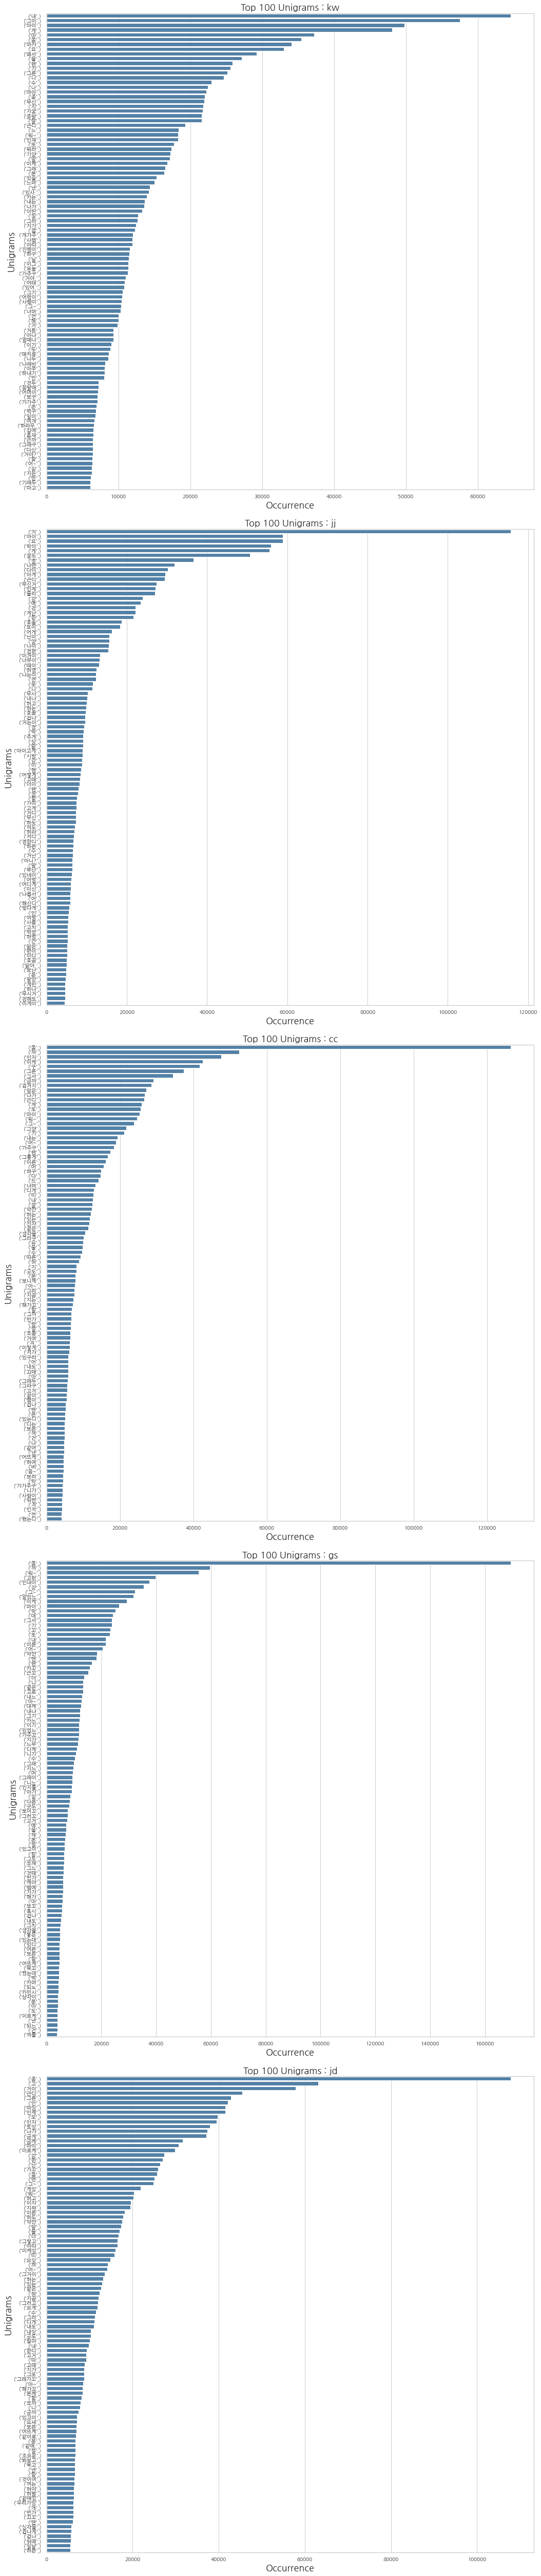

In [19]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(msp_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Unigrams', title = f'Top 100 Unigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

100%|██████████| 241781/241781 [00:19<00:00, 12714.71it/s]


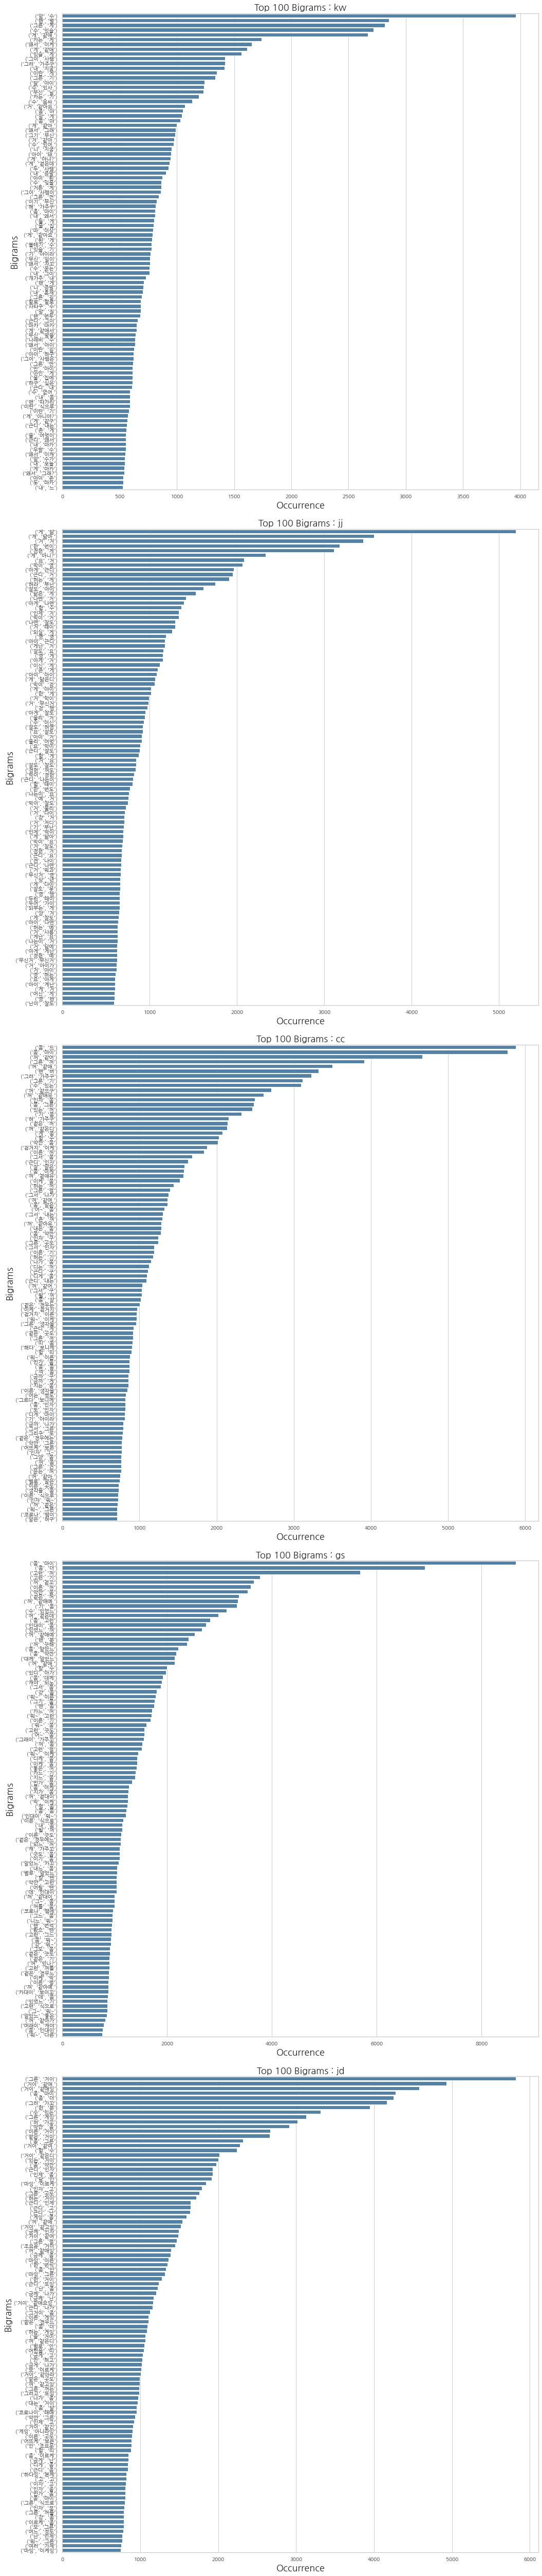

In [20]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(msp_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,2)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Bigrams', title = f'Top 100 Bigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

100%|██████████| 241781/241781 [00:18<00:00, 12883.50it/s]


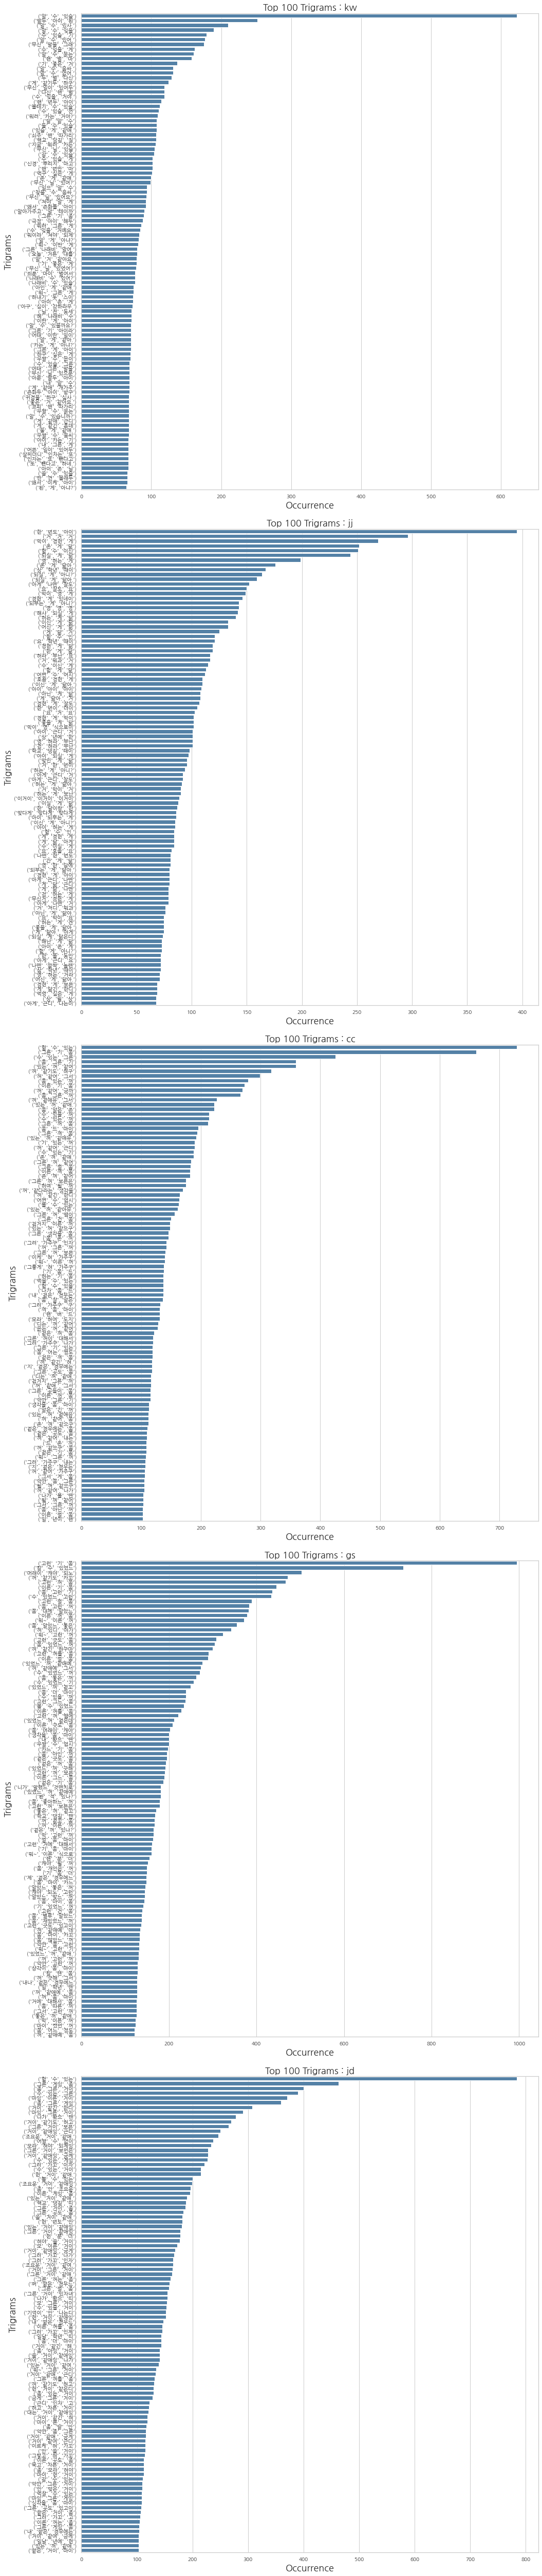

In [21]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(msp_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,3)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Trigrams', title = f'Top 100 Trigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

## Tokenizer별 분산 kdeplot

In [22]:
spm_4000.encode('안녕하세요?!.,')

[50, 3250, 2459, 297, 2475, 3, 2451, 3]

In [23]:
spm_4000.encode_as_pieces('안녕하세요?!.,')

['▁안', '녕', '하', '세요', '?', '!', '.', ',']

- 스페이스바 , 문장 기호 확인 필요 
- remove() 사용하면 문제점 > 해당 단어가 없으면 에러가 뜬다 
- df_train copy해서 ?, ! 문장기호들 제거하는 방법으로 사용 

In [26]:
# 토크나이저 dict 만들기

tokenizers_4000 = {'spm' : spm_4000, 'msp' : msp_4000, 'custom_msp' : custom_msp_4000}
tokenizers_8000 = {'spm' : spm_8000, 'msp' : msp_8000, 'custom_msp' : custom_msp_8000}

In [ ]:
dial = df_train.loc[df_train['reg'] == reg,'dial'].values
df_train['dial_r'] = df_train['dial'].apply(lambda x : re.sub('[?.,!]','',x))

## tokenizer별 분산 확인 

In [29]:
# plot 함수 

import seaborn as sns
from nltk import ngrams

colors = ['r','g','darkviolet','orange','cyan']

def uni_bi_distribution_plot(tokenizer_dic, row, col):
    fig = plt.figure(figsize=(10,10))
    z = 0
    for i, tok in enumerate(tokenizer_dic.items()) :
        key, tokenizer = tok
        for n,reg in enumerate(regs) :
            # unigram
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                tokenized.extend(tok_encode)

            # Barplot that shows the top most common

            sns_pos_1 = plt.subplot(row,col,z+i+1)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

            # Setting axes labels
            sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Unigram Token Distribution by Region')
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend()

        # Bigram
        tok_dict = {}
        idx = 0
        for n,reg in enumerate(regs) :
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                n_grams = ngrams(tok_encode,2)
                for ng in n_grams :
                    try :
                        tokenized.append(tok_dict[ng])
                    except :
                        idx += 1
                        tok_dict[ng] = idx  
                        tokenized.append(tok_dict[ng])

            sns_pos_1 = plt.subplot(row,col,z+i+2)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Bigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1
 
        
        # Trigram
        tok_dict = {}
        idx = 0
        for n,reg in enumerate(regs) :
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                n_grams = ngrams(tok_encode,3)
                for ng in n_grams :
                    try :
                        tokenized.append(tok_dict[ng])
                    except :
                        idx += 1
                        tok_dict[ng] = idx  
                        tokenized.append(tok_dict[ng])

            sns_pos_1 = plt.subplot(row,col,z+i+2)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Trigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1


    plt.tight_layout()
    plt.show()

100%|██████████| 241781/241781 [00:22<00:00, 10976.97it/s]


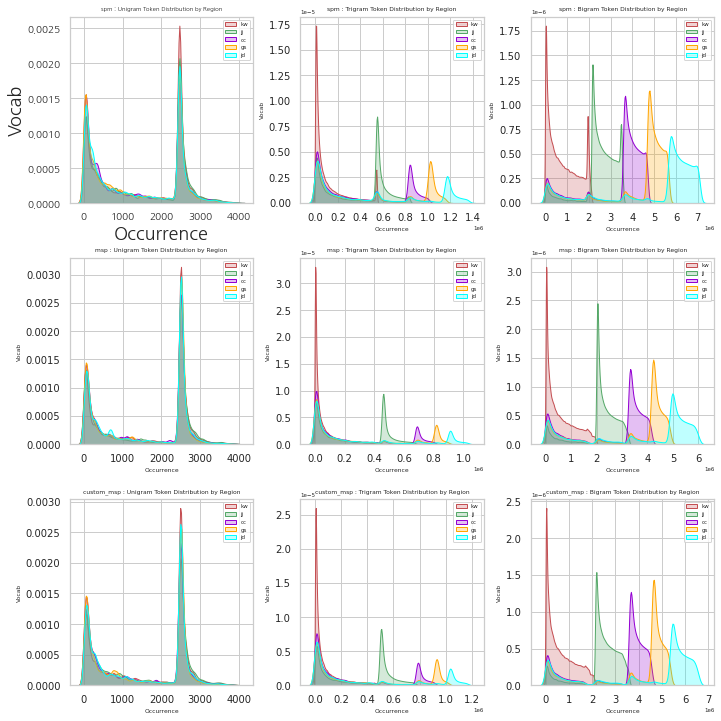

In [30]:
uni_bi_distribution_plot(tokenizers_4000, 3, 3)

100%|██████████| 241781/241781 [00:22<00:00, 10884.43it/s]


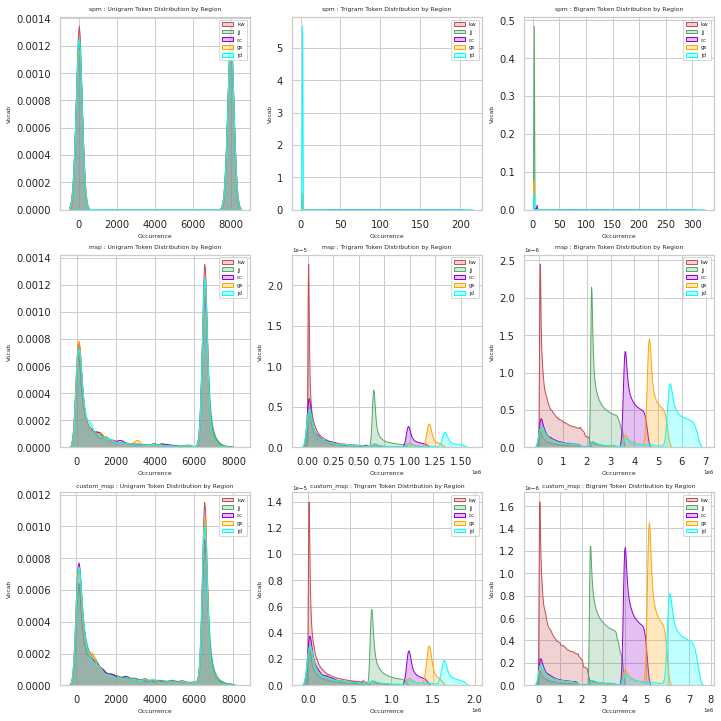

In [31]:
uni_bi_distribution_plot(tokenizers_8000, 3, 3)

### unk count
- OOV 개수 확인

#### 4000

In [32]:
tok_spm= []
tok_msp= []
tok_coustom = []
split_token = set()
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    split_token |= set(i.split())
    tok_spm.extend(spm_4000.encode(i))
    tok_msp.extend(msp_4000.encode(i))
    tok_coustom.extend(custom_msp_4000.encode(i))

100%|██████████| 1340262/1340262 [04:07<00:00, 5417.89it/s]


In [33]:
print('split unk cnt : ', 4000 -  len(split_token)*-1)
print('spm unk cnt : ', tok_spm.count(spm_4000.unk_id()))
print('msp unk cnt : ', tok_msp.count(msp_4000.unk_id()))
print('custom_msp unk cnt : ', tok_coustom.count(custom_msp_4000.unk_id()))

split unk cnt :  752112
spm unk cnt :  525174
msp unk cnt :  50605
custom_msp unk cnt :  48850


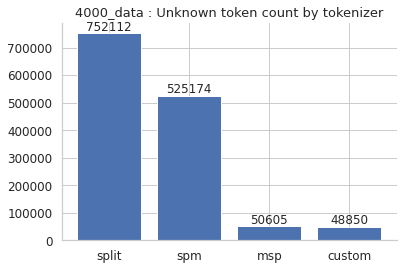

In [34]:
fig, ax = plt.subplots()
bar = ax.bar(x=['split','spm','msp','custom'], height = [752112,tok_spm.count(spm_4000.unk_id()),tok_msp.count(spm_4000.unk_id()),tok_coustom.count(custom_msp_4000.unk_id())])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('4000_data : Unknown token count by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### 8000


In [55]:
split_token = set()
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    split_token |= set(i.split())

100%|██████████| 1340262/1340262 [00:05<00:00, 233992.56it/s]


In [56]:
tok_spm= []
tok_msp= []
tok_coustom = []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    tok_spm.extend(spm_8000.encode(i))
    tok_msp.extend(msp_8000.encode(i))
    tok_coustom.extend(custom_msp_8000.encode(i))

100%|██████████| 1340262/1340262 [03:44<00:00, 5969.90it/s]


In [57]:
print('split unk cnt : ', 8000 -  len(split_token)*-1)
print('spm unk cnt : ', tok_spm.count(spm_8000.unk_id()))
print('msp unk cnt : ', tok_msp.count(msp_8000.unk_id()))
print('custom_msp unk cnt : ', tok_coustom.count(custom_msp_8000.unk_id()))

split unk cnt :  756112
spm unk cnt :  23259088
msp unk cnt :  50605
custom_msp unk cnt :  49086


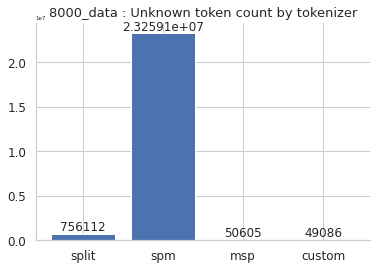

In [58]:
fig, ax = plt.subplots()
bar = ax.bar(x=['split','spm','msp','custom'], height = [756112,tok_spm.count(spm_8000.unk_id()),tok_msp.count(msp_8000.unk_id()),tok_coustom.count(custom_msp_8000.unk_id())])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('8000_data : Unknown token count by tokenizer',fontsize=13) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### subword fertility
- 토큰화된 단어마다 생성되는 부분단어의 평균 개수

In [39]:
# 4000_data

tok_spm= []
tok_msp= []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    #split by empty space
    tok_spm_len_split = len(i.split())
    
    #split by tokenzier
    tok_spm_len = len(spm_4000.encode(i))
    tok_msp_len = len(msp_4000.encode(i))
    tok_custom_len = len(custom_msp_4000.encode(i))
    
    # find percentage of subword split
    tok_spm.append(tok_spm_len / tok_spm_len_split )
    tok_msp.append(tok_msp_len / tok_spm_len_split)
    tok_custom.append(tok_custom_len / tok_spm_len_split)    

100%|██████████| 1340262/1340262 [03:57<00:00, 5646.89it/s]


In [40]:
print('spm subword fertility :',sum(tok_spm)/len(tok_spm))
print('msp subword fertility :',sum(tok_msp)/len(tok_msp))
print('custom_msp subword fertility :',sum(tok_custom)/len(tok_custom))

spm subword fertility : 2.193813034295701
msp subword fertility : 2.312592527239291
custom_msp subword fertility : 2.193100479279696


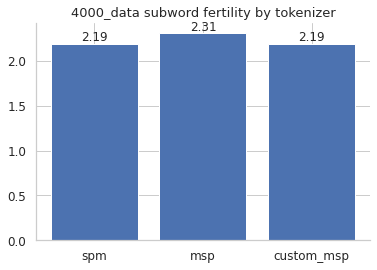

In [41]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/len(tok_spm),2),round(sum(tok_msp)/len(tok_msp),2),round(sum(tok_custom)/len(tok_custom),2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('4000_data subword fertility by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [42]:
# 8000_data

tok_spm= []
tok_msp= []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    #split by empty space
    tok_spm_len_split = len(i.split())
    
    #split by tokenzier
    tok_spm_len = len(spm_8000.encode(i))
    tok_msp_len = len(msp_8000.encode(i))
    tok_custom_len = len(custom_msp_8000.encode(i))
    
    # find percentage of subword split
    tok_spm.append(tok_spm_len / tok_spm_len_split )
    tok_msp.append(tok_msp_len / tok_spm_len_split)
    tok_custom.append(tok_custom_len / tok_spm_len_split)    

100%|██████████| 1340262/1340262 [03:48<00:00, 5864.54it/s]


In [43]:
print('spm subword fertility :',sum(tok_spm)/len(tok_spm))
print('msp subword fertility :',sum(tok_msp)/len(tok_msp))
print('custom_msp subword fertility :',sum(tok_custom)/len(tok_custom))

spm subword fertility : 2.106180825028822
msp subword fertility : 2.1373078740151397
custom_msp subword fertility : 1.961404541170287


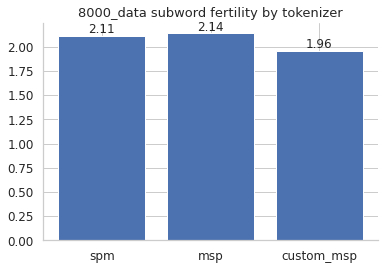

In [44]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/len(tok_spm),2),round(sum(tok_msp)/len(tok_msp),2),round(sum(tok_custom)/len(tok_custom),2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('8000_data subword fertility by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### proportion of continued words
- 말뭉치에서 적어도 두 개의 부분 토큰으로 분할된 토큰화된 단어의 비율 

In [45]:
# 4000_data

tok_spm= []
tok_msp= []
tok_split = []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    total_cnt = 0
    spm_temp = 0
    msp_temp = 0
    custom_temp = 0    
    for k in i.split() :
        if k == ' ' or k ==  '\u200b' or k =='\x9f':
            continue
        total_cnt += 1
        word_spm = spm_4000.encode_as_pieces(k)
        word_msp = msp_4000.encode_as_pieces(k)
        word_custom = custom_msp_4000.encode_as_pieces(k)        
        
        if word_spm[0] == '▁' :
            word_spm.remove('▁')
            
        if word_msp[0] == '▁' :
            word_msp.remove('▁')
            
        if word_custom[0] == '▁' :
            word_custom.remove('▁')
            
        if len(word_spm) > 1 : spm_temp+=1
        if len(word_msp) > 1 : msp_temp+=1
        if len(word_custom) > 1 : custom_temp+=1            
                        
    tok_spm.append(spm_temp)
    tok_msp.append(msp_temp)
    tok_split.append(total_cnt)
    tok_custom.append(custom_temp)    

100%|██████████| 1340262/1340262 [04:57<00:00, 4504.60it/s]


In [46]:
print('spm proportion of continued words :',sum(tok_spm)/sum(tok_split) * 100)
print('msp proportion of continued words :',sum(tok_msp)/sum(tok_split) * 100)
print('custom_msp proportion of continued words :',sum(tok_custom)/sum(tok_split) * 100)

spm proportion of continued words : 55.13527722500944
msp proportion of continued words : 67.53569775943595
custom_msp proportion of continued words : 62.722492988763655


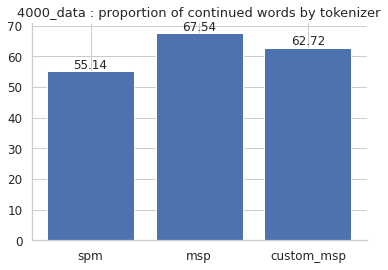

In [47]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/sum(tok_split) * 100,2),round(sum(tok_msp)/sum(tok_split) * 100,2),round(sum(tok_custom)/sum(tok_split) * 100,2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('4000_data : proportion of continued words by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [48]:
# 8000_data

tok_spm= []
tok_msp= []
tok_split = []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    total_cnt = 0
    spm_temp = 0
    msp_temp = 0
    custom_temp = 0    
    for k in i.split() :
        if k == ' ' or k ==  '\u200b' or k =='\x9f':
            continue
        total_cnt += 1
        word_spm = spm_8000.encode_as_pieces(k)
        word_msp = msp_8000.encode_as_pieces(k)
        word_custom = custom_msp_8000.encode_as_pieces(k)        
        
        if word_spm[0] == '▁' :
            word_spm.remove('▁')
            
        if word_msp[0] == '▁' :
            word_msp.remove('▁')
            
        if word_custom[0] == '▁' :
            word_custom.remove('▁')
            
        if len(word_spm) > 1 : spm_temp+=1
        if len(word_msp) > 1 : msp_temp+=1
        if len(word_custom) > 1 : custom_temp+=1            
                        
    tok_spm.append(spm_temp)
    tok_msp.append(msp_temp)
    tok_split.append(total_cnt)
    tok_custom.append(custom_temp)    

100%|██████████| 1340262/1340262 [04:40<00:00, 4780.03it/s]


In [49]:
print('spm proportion of continued words :',sum(tok_spm)/sum(tok_split) * 100)
print('msp proportion of continued words :',sum(tok_msp)/sum(tok_split) * 100)
print('custom_msp proportion of continued words :',sum(tok_custom)/sum(tok_split) * 100)

spm proportion of continued words : 7.600593433606659
msp proportion of continued words : 63.423911180872416
custom_msp proportion of continued words : 55.92501985902404


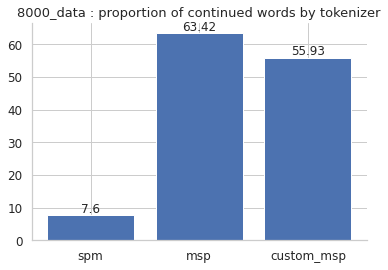

In [50]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/sum(tok_split) * 100,2),round(sum(tok_msp)/sum(tok_split) * 100,2),round(sum(tok_custom)/sum(tok_split) * 100,2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('8000_data : proportion of continued words by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Wordcloud

In [51]:
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.font_manager as fm

In [52]:
from collections import Counter

In [73]:
from konlpy.tag import Mecab
mecab = Mecab()

In [75]:
dial = df_train.dial.values

In [76]:
df_train['token'] = df_train['dial'].apply(mecab.morphs)

In [78]:
counter = Counter()
for i in df_train.token :
    counter.update(i)
counter.most_common(30)

[('이', 1696238),
 ('.', 1244924),
 ('가', 879735),
 ('는', 780776),
 ('하', 584246),
 ('게', 560331),
 ('고', 528576),
 ('을', 485333),
 ('어', 470998),
 ('거', 464850),
 ('?', 464280),
 ('에', 444899),
 ('도', 435993),
 ('은', 412780),
 ('있', 410805),
 ('지', 404022),
 ('나', 396054),
 ('쫌', 360430),
 ('그', 356773),
 ('구', 355267),
 ('~', 348326),
 ('를', 325656),
 ('아', 322625),
 ('꼬', 309606),
 ('느', 289398),
 ('들', 287596),
 ('내', 262223),
 ('다', 238730),
 ('기', 232866),
 ('잉', 229252)]

100%|██████████| 241781/241781 [00:20<00:00, 11580.84it/s]


<Figure size 1080x5040 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

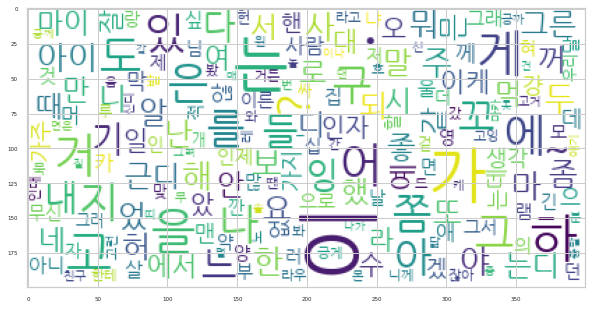

In [81]:
fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))
    
    font_list = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    font_list[0][1]
    wc = WordCloud(font_path= font_list[0][1], background_color='white',max_font_size=60)
    cloud = wc.generate_from_frequencies(counter)
    fig = plt.figure(figsize =(10,10))
    
plt.imshow(cloud)
plt.show()

#     # Barplot that shows the top most common
    
#     plt.subplot(5,1,i+1)
#     sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
#     sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

#     # Setting axes labels
#     sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Unigrams', title = f'Top 100 Unigrams : {reg}')
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)

    
# plt.tight_layout()
# plt.show()

In [1]:
fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,2)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))
    
    font_list = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    font_list[0][1]
    wc = WordCloud(font_path= font_list[0][1], background_color='white',max_font_size=60)
    cloud = wc.generate_from_frequencies(counter)
    fig = plt.figure(figsize =(10,10))
    
plt.imshow(cloud)
plt.show()

NameError: name 'plt' is not defined

In [69]:
import seaborn as sns
from nltk import ngrams

colors = ['r','g','darkviolet','orange','cyan']
dial = df_train.loc[df_train['reg'] == reg,'dial'].values
df_train['dial_r'] = df_train['dial'].apply(lambda x : re.sub('[?.,!]','',x))

def uni_bi_wordcloud_plot(tokenizer_dic, row, col):
    fig = plt.figure(figsize=(10,10))
    z = 0
    for i, tok in enumerate(tokenizer_dic.items()) :
        key, tokenizer = tok
        for n,reg in enumerate(regs) :
            # unigram
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            counter = Counter()
            counter.update(dial)
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                tokenized.extend(tok_encode)

             # font path http://corazzon.github.io/matplotlib_font_setting
            font_list = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
            font_list[0][1]
            wc = WordCloud(font_path= font_list[0][1], background_color='white',max_font_size=60)
    
    
            cloud = wc.generate_from_frequencies(counter)

        
        
        
        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Bigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1


    plt.tight_layout()
    plt.show()
        
        
        

100%|██████████| 241781/241781 [00:14<00:00, 16413.83it/s]
No handles with labels found to put in legend.
100%|██████████| 241781/241781 [00:14<00:00, 17053.19it/s]
No handles with labels found to put in legend.
100%|██████████| 241781/241781 [00:12<00:00, 18821.97it/s]
No handles with labels found to put in legend.


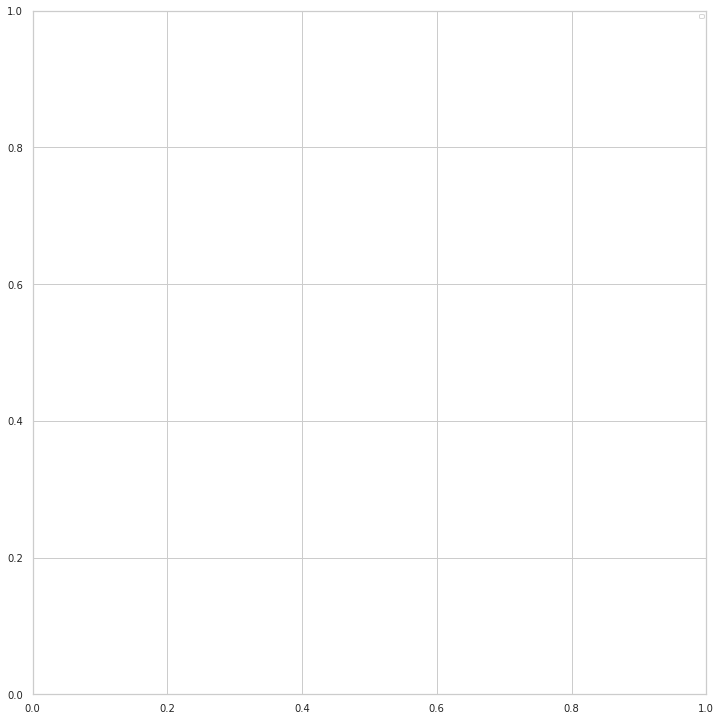

In [70]:
uni_bi_wordcloud_plot(tokenizers_4000, 3, 3)

In [ ]:
uni_bi_wordcloud_plot(tokenizers_8000, 3, 3)

In [62]:
plt.figure(figsize= (20,20))
    
    
for i, reg in enumerate(regs) :
    counter = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        counter.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

  
    # font path http://corazzon.github.io/matplotlib_font_setting
    font_list = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    font_list[0][1]
    wc = WordCloud(font_path= font_list[0][1], background_color='white',max_font_size=60)
    
    
    cloud = wc.generate_from_frequencies(counter)
    
    plt.subplot(3,2,i+1)
    plt.ylabel(reg)
    plt.imshow(cloud)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.suptitle('지역별 most-common 워드클라우드',  font ='NanumGothic')
plt.tight_layout()
plt.show()

100%|██████████| 496436/496436 [00:31<00:00, 15864.46it/s]


TypeError: expected string

<Figure size 1440x1440 with 0 Axes>

## 도와주신 코드 

idx =0
ngram_vocab = {}
tokenized = []
ngrams_test = ngrams(text,2)
for ng in ngrams_test :
	ng = ' '.join(ng)
	if not ngram_vocab_dict[ng] :
		idx += 1
		ngram_vocab[ng] = idx
	tokenized.append(ngram_vocab[ng])

# ngram_idx[i]  for i in range(190000, 200000)
# ngram_idx = { v : k for k, v in ngram_vocab.items() 